# Title:  Overview of Supervised Machine Learning
## Part 1 - Algorithms With Linear Decision Boundaries.

# Prequisites
Experience:  Beginner
Professional Experience:  No Industry Experience

# Introduction

Supervised learning is a class of algorithms that aim to approximate the function $f(\mathbf{x})$ that maps $\mathbf{x}$, a set of predictor or feature variables,  to $Y$, the value we wish to predict.  In other words, these algorithms try to solve $Y = f(\mathbf{x})$.  

Supervised learning algorithms solve two general classes of problems: ***classification***, when $Y$ represents a set of categories, and ***regression*** when $Y$ is continuous.

For example, we may wish to predict the age of an Abalone snail ($Y$).  To accomplish this we may use a number of physical features such as sex, physical dimensions, and weight ($\mathbf{x}$).  Supervised learning algorithms are well-suited for this type of task.  If we consider the age as a continous number, we are solving a regression problem.  We can also bin the age so that any age greater than 11 years is classified as 'Old' and any age less than or equal to 11 years is classified as 'Young', and in that case we are solving a classification problem.   


# Objectives

In Part 1 of the tutorial we will accomplish the following objectives:

*  Understand the loss function, and its minimization as the main goal of supervised machine learning algorithms.


*  Review the set of machine learning algorithms with linear decision boundaries, and provide simple Python implementations of each algorithm.


*  Explain the 'kernel trick', a method that enables classifiers with linear decision boundaries to be used in data that is not linearly seperable.  

## Labeled Data

We first need to collect a set of data that contains physical features, $\mathbf{x}$, and ages, $Y$ for snails that we already know.  This is known as a labeled data set because each snail whose physical dimensions we know in this data set is **labeled** with an age, $Y$.

For this overview we'll use a previously collected labeled data set.  It contains the physical features Sex, Length, Diameter, Whole Weight, Shucked Weight, Viscera Weight, Shell Weight.  It also contains a column for the number of Rings a snail's shell has.  We can use this to create a column for Age, which is defined as the number of rings + 1.5.  We will also create an age class, with values of 0 and 1 for 'Young' and 'Old', respectively.

In [ ]:
#   Metadata - 
#   Source:  http://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.names
#
#   Name                Data Type   Units   Description
#   ----                ---------   -----   -----------
#   Sex                 nominal             M, F, and I (infant)
#   Length              continuous  mm      Longest shell measurement
#   Diameter            continuous  mm      perpendicular to length
#   Height              continuous  mm      with meat in shell
#   Whole weight        continuous  grams   whole abalone
#   Shucked weight      continuous  grams   weight of meat
#   Viscera weight      continuous  grams   gut weight (after bleeding)
#   Shell weight        continuous  grams   after being dried
#   Rings               integer             +1.5 gives the age in years

In [2]:
from IPython.display import display
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline
import pandas as pd

np.random.seed(5000) #for reproducibility
rnd_state = 5000 #for reproducibility 



dat = pd.read_csv('../data/abalone.csv')  #Read in the data
dat['Age'] = dat['Rings'] + 1.5  #Age is defined as the number of rings in the shell + 1.5
dat['AgeClass'] = 0
dat['AgeClass'][dat.Age > 11] = 1

/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [3]:
dat.head()

,Sex,Length_mm,Diameter_mm,Height_mm,WholeWeight_g,ShuckedWeight_g,VisceraWeight_g,ShellWeight_g,Rings,Age,AgeClass
0,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7,8.5,0
1,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9,10.5,0
2,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10,11.5,1
3,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7,8.5,0
4,I,0.425,0.300,0.095,0.3515,0.1410,0.0775,0.120,8,9.5,0


In [5]:
#Let's rename the columns so they are easier to work with
dat.columns=['Sex', 'Length', 'Diameter', 'Height', 'WholeWeight', 'ShuckedWeight', 
         'VisceraWeight', 'ShellWeight', 'Rings', 'Age', 'AgeClass']

Next we will split the data set into the features, $\mathbf{x}$, and the labels, $Y$.

In [6]:
x = dat[['Sex', 'Length', 'Diameter', 'Height', 'WholeWeight', 'ShuckedWeight', 
         'VisceraWeight', 'ShellWeight', 'Rings']]
Y = dat[['Age', 'AgeClass']]

In [7]:
display(x.head())
display(Y.head())

,Sex,Length,Diameter,Height,WholeWeight,ShuckedWeight,VisceraWeight,ShellWeight,Rings
0,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
1,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
2,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
3,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7
4,I,0.425,0.300,0.095,0.3515,0.1410,0.0775,0.120,8


,Age,AgeClass
0,8.5,0
1,10.5,0
2,11.5,1
3,8.5,0
4,9.5,0


## The Loss Function:  Error and Regularization

Broadly speaking, machine learning algorithms typically have two competing goals.    

The first goal is to minimize the difference between $Y$, the actual data labels, and the labels predicted by the algorithm.  This difference between the actual $Y$ and the predicted $Y$ is known as the error, and the function that describes it is called the **error function**.

However, we typically don't know the true function $f(\mathbf{x})$ that maps $\mathbf{x}$ to $Y$, and collected data is often noisy.  If we focus only on minimizing error, we would be better served by a function with many parameters, because with each parameter the function becomes more flexible and can more closely follow the data points in our data sample.  However, because we don't know which fluctuations in our data are due to the true $f(\mathbf{x})$ and which are due to noise, this approach puts us in danger of fitting the noise in the data as we attempt to approximate $f(\mathbf{x})$.  This is known as **overfitting** and because each data set contains different noise fluctuations a model that overfits and performs well on one data sample will be a very poor fit and not generalize well to other data samples.

The second goal of machine learning algorithms therefore becomes to prevent fitting this noise.  Typically this is done by a method called **regularization**.  Conceptually, regularization is just a quantitative application of *Occam's Razor* to a model, which states that among competing hypotheses or models, the one with the fewest assumptions or parameters should be selected.  To accomplish this goal, regularization introduces a penalty term, $R(f)$, that scales with the complexity of the model.  The more parameters to fit and knobs to turn a model has, the larger this penalty.  However, regularization that is too strong can lead to models that are too simple to approximate the true $f(\mathbf{x})$, thereby **underfitting** the data.

This competition between low error and low complexity can be viewed through the lense of the **bias / variance tradeoff**.  A given data set may be resampled many times over, and a model may be fit to each sample.  A model that is too simple will generally produce very repeatable predictions, or in other words the model's predictions will have low variance, which is desirable - we should be getting similar predictions since the true function $f(\mathbf{x})$ is unchanged by resampling the data.  However, such a model will not follow data points within each data resample closely but will instead systematically deviate from them, or in other words the model will have high bias.  On the other hand a model that is more complex will more closely follow the data points in each data resample, thereby having low bias, which is desirable.  But such a model will produce very different predictions when fitted to different resamples of the data.  This is because the model will be partly fitting noise fluctuations unique to each data resample, and this noise will drive its predictions.  This model will have high variance.

As illutrated in the following figure, the two goals to minimize error and reduce complexity compete with each other.  The left panel in the figure shows a very simple model (red) with low complexity but high error.  This model is underfitting the data (blue).  The panel on the far right shows a model with very low error, but this reduction in error comes with much more complexity, and is likely overfitting the data.  Although it has low error in the data sample to which it has been fit, its error in other data samples will be high.  The middle panel shows a good balance between error reduction and complexity.  Achieving this balance is the goal of successful application of machine learning.  

<img src="../images/over_and_under_fitting.png">

Stated more succinctly, all machine learning algorithms are methods that try to minimize a **loss function**, a function that combines the error function and a regularization penalty for complexity.

## Train / Test Data Split

We will use the features in $\mathbf{x}$ to train a series of supervised algorithms to learn how these features map to the labels in $Y$.  In order to be able to test how the algorithms perform, we'll need two sets of data, one that the algorithms are trained on, and one that the algorithms have not seen.  So we'll first begin by splitting our data into two sets - a training set containing 75% of the data, and a test set containing 25% of the data.

In [8]:
from sklearn.cross_validation import train_test_split
x_train, x_test, Y_train, Y_test = train_test_split(x, Y, test_size=0.25, 
                                                    random_state=rnd_state)
x_train.reset_index(drop=True, inplace=True)
x_test.reset_index(drop=True, inplace=True)
Y_train.reset_index(drop=True, inplace=True)
Y_test.reset_index(drop=True, inplace=True)

We will also define a few functions to allow us to easily evaluate performance of the different algorithmis we will review.

In [9]:
#Model evaluation functions

from sklearn.metrics import confusion_matrix, mean_squared_error
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    
    This function prints and plots the confusion matrix.
    (adapted from sklearn confusion matrix examples)
    
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    cm_norm = np.round(100.*cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], 1)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, str(cm[i, j]) + ' (' + str(cm_norm[i, j]) + '%)',
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    
def eval_classifier(Y_pred, Y_test, score, class_names):
    
    """
    
    This function will generate diagnostics and plots for classifier models.
    
    """
    
    print('Percent of correct classifications = ' + str(round(100*score, 2)))


    cnf_matrix = confusion_matrix(Y_test, Y_pred);


    plt.rcParams['figure.figsize'] = [16, 6]

    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=False,
                          title='Confusion matrix')

    

def eval_regressor(Y_pred, Y_test, Y_predTr, Y_train):
    
    """
    
    This function will generate diagnostics and plots for regressor models.
    
    """
    
    plt.scatter(Y_pred, Y_test, label = 'Data')
    plt.plot([np.min(Y_pred), np.max(Y_pred)], [np.min(Y_pred), np.max(Y_pred)],
            linestyle = 'dashed', color = 'black', linewidth = 3, label = 'Unity Line')
    plt.legend(loc = 2)
    plt.xlabel('Predicted Values')
    plt.ylabel('Actual Values')
    plt.show();
    
    print('RMSE Test = ' + str(np.sqrt(mean_squared_error(Y_pred, Y_test))))
    print('RMSE Train = ' + str(np.sqrt(mean_squared_error(Y_predTr, Y_train))))
    
np.set_printoptions(precision=2)

In [10]:
#Set a figure size and figure font size
plt.rcParams['figure.figsize'] = [16, 6]
plt.rcParams['font.size'] = 15

# Supervised Learning Algorithms - Part 1

## Generalized Linear Models

Generalized linear models (GZLMs) assume that $Y$ is a linear combination of the features in $\mathbf{x}$.  Therefore, these models have the form:

$$Y = w_o + w_1x_1 + w_2x_2 + ... + w_nx_n$$

The goal of the algorithm is to find values of each $w$ so that given a set of features $\mathbf{x}$, the right side of the equation is as close to all of the known $Y$ values as possible.  Intuitively, a line (for only one feature) or a hyperplane (for more than one features) is fit to the data in such a way as to minimize the combined error for all points between the right side of the equation and the left side of the equation.

GZLMs can solve both regression problems and classification problems.

### Solving Regression Problems - Ordinary Least Squares

Ordinary Least Squares (OLS) models are perhaps the simplest linear models that can be used to solve regression problems.  Conceptually, OLS is a method that minimizes the sum of the (squares of the) differences between the predicted $Y$ labels of a model and the actual $Y$ labels that are observed in the data.  Rather than implementing this from scratch, we can use sklearn's implemention to accomplish this with just a single line of code.

For illustrative purposes we'll first fit a simple model with only one predictor, *Length*, and then fit the full model.

In [189]:
from sklearn.linear_model import LinearRegression

# The fit_interecept tells us that we want to fit w_0, otherwise known as the 'intercept'
# from the equation above.
# If set to false, w_0 is set to 0, and only the other w_n coefficients are fit.
model = LinearRegression(fit_intercept = True)

In [190]:
model.fit(x_train['Length'].to_frame(), Y_train['Age'].to_frame())

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [191]:
print('Length w:  ' + str(model.coef_[0]))

Length w:  [ 14.91]


The figure below shows that this model fits the line that minimizes the combined total distance of the actual data points from that line.  The predicted value of *Age* for a given *Length* can then be directly read from the line.  For example, for a *Length* of 0.8 mm, the predicted *Age* is a bit more than 15 years old.  The fitted coefficient for *Length*, which can be retrieved from **model.coef\_** and has a value of 14.91, is the slope of this line.  It tells us that for each 1 mm increase in *Length*, *Age* increases by 14.91 years. 

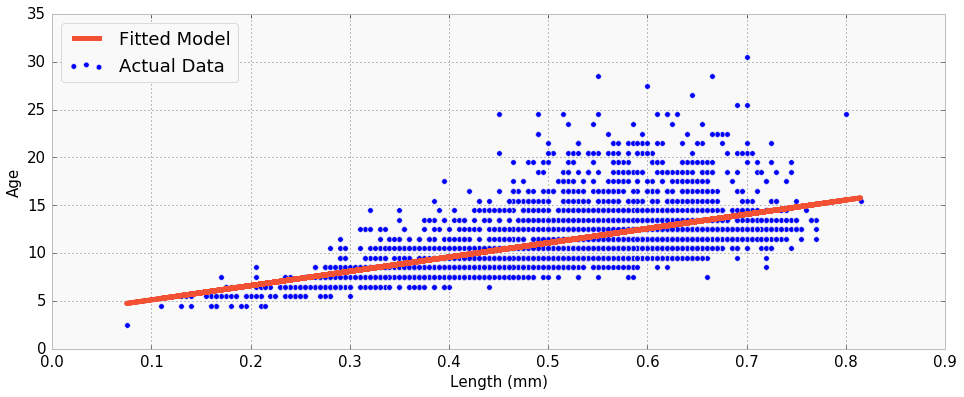

In [130]:
plt.scatter(x_train['Length'], Y_train['Age'], s = 30, label = 'Actual Data')
plt.plot(x_train['Length'], model.predict(x_train['Length'].to_frame()), 
         linewidth = 5, markersize = 0, label = 'Fitted Model')
plt.xlabel('Length (mm)')
plt.ylabel('Age')
plt.legend(loc = 2);
plt.show();

We can now fit the model with all of the predictor variables.  Although this is difficult to visualize, adding more predictors does exactly what we saw with the single predictor.  For example, with two predictors, we have a 3D plot with the vertical axis being *Age* and the other two axes being the two predictors.  Rather than a line we fit a 2D plane to the data.  As the number of predictors increases, so do the dimensions of the plane we are fitting so that the fitted plane always has (number of predictors - 1) dimensions.  Higher dimensional planes are called **hyperplanes**.   

#### Encoding Categorical Features

Before we can fit our model with all of the features we need to somehow deal with the *Sex* feature, which is categorical.  One thing we can do is to **one-hot** encode the feature.  Since *Sex* has 3 levels (Male, Female, Infant) this will break *Sex* into 3 different features - M, F, and I.  When *Sex* is Male, M will be set to 1, F to 0, and I to 0.  When *Sex* is Female, F will be set to 1, M to 0, and I to 0. And when *Sex* is Infant, M will be set to 0, F to 0, and I to 1.  You can see that this encoding carries the same information as the original encoding.  Another name for the 3 new features we created is **category dummy variables**.

It turns out there is already a function **get_dummies( )** to do this for us.  So we will use this function to generate our new *Sex* features and then use all of our features in model.

In [11]:
sex_dummies = pd.get_dummies(x_test['Sex'])
x_test[['F','M','I']] = sex_dummies[['F','M','I']]

sex_dummies = pd.get_dummies(x_train['Sex'])
x_train[['F','M','I']] = sex_dummies[['F','M','I']]
x_train[['Sex','F','M','I']].head(10)

/usr/local/lib/python2.7/dist-packages/pandas/core/frame.py:2320: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


,Sex,F,M,I
0,I,0,0,1
1,M,0,1,0
2,F,1,0,0
3,F,1,0,0
4,M,0,1,0
5,M,0,1,0
6,I,0,0,1
7,I,0,0,1
8,I,0,0,1
9,I,0,0,1


In [192]:
# Let's select our features and fit the model.
# We use .to_frame() because sklearn likes data frames, 
# and Y_train['Age'] is instead a data series.
feature_names = ['M','I', 'Length', 'Diameter', 'Height', 'WholeWeight', 
 'ShuckedWeight', 'VisceraWeight', 'ShellWeight']
model.fit(x_train[feature_names], Y_train['Age'].to_frame())

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

Because the fitted hyperplane is difficult to visualize, we will instead look at the fit coefficients, or the $w_n$s, which as we discussed are the slopes of the fitted hyperplane in the dimension of each respective predictor.  The following summary table shows the fit parameters of the model.  Each of the coefficients shows how much *Age* changes for each unit of the corresponding physical feature.  For example, for every unit of 1 mm of *Height*, *Age* increases by 9.58 years.  

In [193]:
print('Fitted Coefficients:')
print('--------------------')
print('')
print('{0: <20}'.format('Intercept:') + '|' +  '\t' + str(model.intercept_[0]))
for i, f in enumerate(feature_names):
    print('{0: <20}'.format(f + ':') + '|' +  '\t' + str(model.coef_[0][i]))

Fitted Coefficients:
--------------------

Intercept:          |	5.41430281728
M:                  |	0.0967725180643
I:                  |	-0.799389862979
Length:             |	-0.966818336488
Diameter:           |	12.0920727577
Height:             |	9.57719924565
WholeWeight:        |	8.76178614893
ShuckedWeight:      |	-19.4042915446
VisceraWeight:      |	-11.6170177984
ShellWeight:        |	9.58916152143


We should also note the categorical predictor, *Sex*.  In the data, *Sex* has 3 levels - Male (M), Female (F), and Infant (I).  The combination of the intercept, $w_0$, and the Male (M) and Infant (I) categories perfectly determine the Female (F) category level.  Female (F) is only equal to 1 when Male (M) is not 1 and Infant (I) is not 1, and  we're not at the intercept where all features are 0.  Otherwise Female (F) is 0.  In other words, the Female (F) category level contains fully redundant information that exists in our other features.  When multiple predictors have strong correlatoins like this, known as **multicollinearity**, linear regression models can fail to correctly estimate predictor coefficients. We must remove this redundancy by either removing the intercept from the model or removing one of the category levels.

In our case we opted to remove the Female (F) level.  The level that is removed becomes the baseline to which all the other levels of the category are compared.  As a result coefficients in our model for the Male (M) and Infant (F) features are relative to the Female (F) sex.  That is, the coefficient for Male (M) of 0.097 is small and suggests that being Male is not strongly predictive of age compared to being Female.  It tells us that in the training data on average Male snails are only 0.097 years older than Female snails.  However, Infant (I) snails, which should tend to be younger than Female snails, have a coefficient of -0.80, being on average 0.80 years younger than Females.  
 
This model can now be used to predict the age of an Abalone snail given its various physical characteristics.  We can try to predict the age of the snails in our test data set, and see how well the model performs.

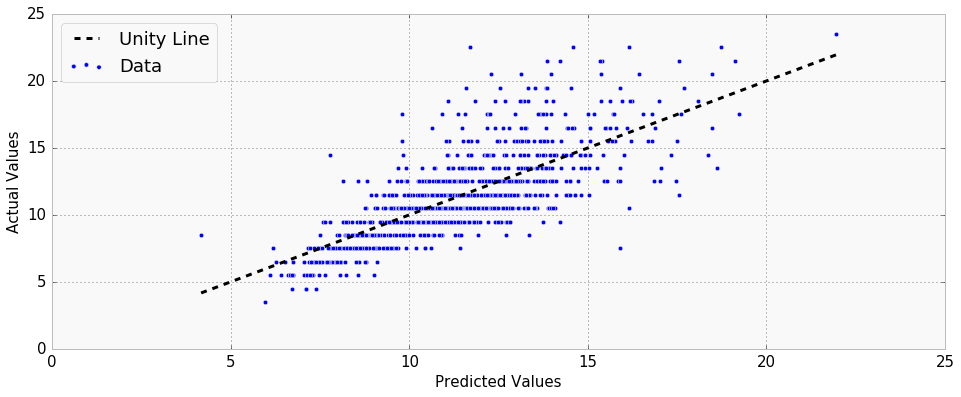

RMSE Test = 2.06763240034
RMSE Train = 2.23048066399


In [194]:
# Generate prediction for the test and training sets
Y_pred = model.predict(x_test[feature_names])
Y_predTr = model.predict(x_train[feature_names])

# Plot predicted vs actual values, and compute RMSE
eval_regressor(Y_pred, Y_test['Age'], Y_predTr, Y_train['Age'])

The figure above shows predicted values for snails' ages on the X-axis and actual ages on the Y-axis.  The blue points are the actual data in our test set - new snails that the model has not seen.  The dashed black line is the 'unity' line, that is, the line $Y = x$.  Points falling on this line are perfect predictions.  Points below the line are predictions for which the predicted age is larger than the actual age, and points above the line are predictions for which the predicted age is smaller than the actual age.  We can see that although data points don't all fall on the line, they generally follow the diagonal pattern of the line.  This reveals that our model is able to predict age with some accuracy better than chance, for which data points would instead appear as a cloud.

Quantitatively we can use the mean squared error (or its square root, the RMSE) to compare different models.  We can also compare the RMSE of the test data to that of the training data.  If the RMSE of the test data is much smaller than that of the training data that could be evidence of overfitting.

### Solving Classification Problems - Logistic Regression

Contrary to what it's name may suggest, Logistic Regression is used to solve classification problems.  In this classification problem a snail's age label, $Y$, has been split into one of two classes, 'Young', encoded as class 0, and 'Old', encoded as class 1.  Our strategy will be to determine the probability that a snail is 'Old' given a set of physical features, and if that probability is greater than 50%, we'll say the snail is 'Old'.  Otherwise we'll say the snail is 'Young'. 

We want to model the probability of $Y$ being class 1 given its features $\mathbf{x}$.  Formally this conditional probability can be written as $P(Y = 1 | X = \mathbf{x})$.  We'll further simplify this notation by defining $p(\mathbf{x})$ = $P(Y = 1 | X = \mathbf{x})$ and use $p(\mathbf{x})$ from now on.

Since we are using a linear model in this section, we want to define a linear model for $p(\mathbf{x})$ such that:

$$p(\mathbf{x}) = w_o + w_1x_1 + w_2x_2 + ... + w_nx_n$$

Not surprisingly, this equation looks very similar to the equation we saw earlier describing GZLMs.  However, because probability can only take values between 0 and 1 and in the above function $p(\mathbf{x})$ is unbounded and can take any values even outside the range 0 and 1, this model will not work.  We need to modify the equation so that it is also bounded to values between 0 and 1. 

A simple model we can use instead, and the equation for logistic regression, is:

$$ln\left(\frac{p(\mathbf{x})}{1-p(\mathbf{x})}\right) = w_o + w_1x_1 + w_2x_2 + ... + w_nx_n$$

This model has the properties that changes in $\mathbf{x}$ multiplicitively scale (rather than add to) the probability for class 1, and $p(\mathbf{x})$ is also bounded between 0 and 1.

To get a better sense of what we've done, can solve this equation for the initial quantity we were interested in, $p(\mathbf{x})$, the probability of having class 1 given the features $\mathbf{x}$ we observe.  This gives:

$$p(\mathbf{x}) = \frac{1}{1 + e^{-(w_o + w_1x_1 + w_2x_2 + ... + w_nx_n)}}$$

This is a sigmoid (S-shaped) equation that describes the probability of having class 1 given the features in $\mathbf{x}$.  To get a more intuitive sense of how this works, we'll now fit this model to our data with a single feature, *Length*.

In [137]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()

model.fit(x_train['Length'].to_frame(), Y_train['AgeClass'].to_frame())

/usr/local/lib/python2.7/dist-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0)

In sklearn's implementation of Logistic Regression, $w_0$ is stored in **model.intercept\_** and $w_1$ is stored in **model.coef\_**.  We don't have any more $w_n$ since we only have a single $x$ feature, *Length*.  The fitted function is shown in the figure below in red.  The blue dots represent the actual data.  In order to use the fitted function for classification, we first need to find the value of *Length* on the X-axis that corresponds to a 0.5 probability of a snail being class 1 ('Old').  Any *Length* for which the probability of class 1 is greater than 0.5 will be classified as 'Old' and any *Length* for which the probability of being class 1 is less than 0.5 will be classified as 'Young'.  

In order to find this, we need to solve the logistic equation for the value that $x_1$ takes when setting $p(x)$ to $0.5$:

$$p(x) = \frac{1}{1 + e^{-(w_o + w_1x_1)}} = 0.5$$

$$\Rightarrow x_1^{p(x) = 0.5} = \frac{ln\left(\frac{1}{0.5} - 1\right) + w_o}{-w_1}$$

or equivalently

$$\Rightarrow x_1^{p(x) = 0.5} = \frac{ln\left(\frac{0.5}{1 - 0.5}\right) - w_o}{w_1}$$

The dashed vertical dividing line in the figure below shows this value of $x_1$.  Any snails with length less than this value are classified as class 0, 'Young', and any snails with length greater than this value are classified as class 1, 'Old'.  This value of $x_1$ and the associated dividing line are called the **decision boundary**.  

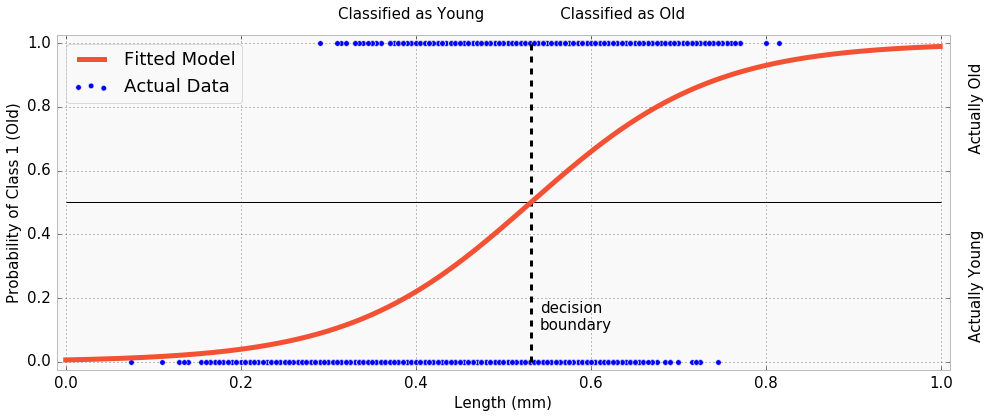

In [138]:
# Set the range of Length for which to generate p(x).
predict_domain = np.arange(0,1,0.001)[:, None]

# Generate p(x) values and plot them
predictions = model.predict_proba(np.arange(0,1,0.001)[:, None])[:,1]
plt.plot(predict_domain, predictions, linewidth = 5, markersize = 0, label = 'Fitted Model')

#Compute the location of the decision boundary
decision_boundary = (np.log((1 / 0.5 ) -1) + model.intercept_) / (-model.coef_)

# Plot the actual data
plt.scatter(x_train['Length'], Y_train['AgeClass'], s = 30, label = 'Actual Data')
plt.hlines(0.5,0,1)

# Plot the decision boundary
plt.vlines(decision_boundary, 0, 1, linestyle = 'dashed', linewidth = 3)

# Add labels and other settings for the plot
plt.xlim([-0.01, 1.01])
plt.ylim([-0.025, 1.025])
plt.annotate('decision\nboundary', xy=(decision_boundary + 0.01, 0.1), xycoords='data', 
             annotation_clip=False)
plt.xlabel('Length (mm)')
plt.ylabel('Probability of Class 1 (Old)')
plt.legend(loc = 2);
plt.annotate('Classified as Young                Classified as Old'.encode(), 
             xy=(decision_boundary - 0.22, 1.075),xycoords='data', annotation_clip=False);
plt.annotate('Actually Young                Actually Old'.encode(), 
             xy=(decision_boundary + 0.5, 0.9),xycoords='data', annotation_clip=False, rotation = 90);

Notably, any data that falls on the top right or bottom left quadrants is correctly classified, and any data that falls in the top left or bottom right quadrants is incorrectly classified. In practice we don't have to manually look at the decision boundary and manually classify data - the **model.predict()** method will do this for us.  But the above figure gives us a sense of how this classification is done.

We can now add back all of our $\mathbf{x}$ features to the model and make a classification prediction using all of them.  Intuitively, when we do this, rather than fitting an S-shaped line to the data we are fitting an S-shape hyperplane.

In [12]:
# We don't have to worry about excluding a category level from here on, so let's just use
# all features
feature_names = ['M', 'F', 'I', 'Length', 'Diameter', 'Height', 'WholeWeight', 'ShuckedWeight', 'VisceraWeight',
                'ShellWeight']

In [140]:
# Fit the logistic regression model
model = LogisticRegression()
model.fit(x_train[feature_names], Y_train['AgeClass'].to_frame())

/usr/local/lib/python2.7/dist-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0)

Again, fitting the model is as simple as a single line of code.  We can evaluate the model like we did with the OLS model.  For classification models RMSE is not as meaningful, so we'll instead measure the percent of total snails that were classified correctly.  The function **model.score( )** will automatically compute this for us.

Percent of correct classifications = 75.96


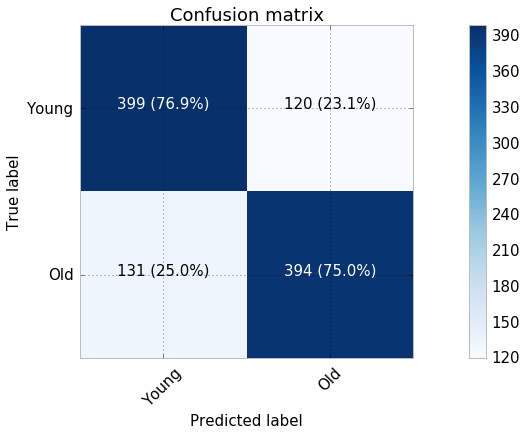

In [141]:
# Specify classes in the model
class_names = ['Young', 'Old']

# Compute the model's classification accuracy on the test data set
score = model.score(x_test[feature_names], Y_test['AgeClass'])

# Generate new predictions from the test data set
Y_pred = model.predict(x_test[feature_names])

# Report percent correct and plot confusion matrix
eval_classifier(Y_pred, Y_test['AgeClass'], score, class_names)

We classified 76% of the snails correctly, that's pretty good!  The figure above, called a **confusion matrix** is a way to look at model performance in classification tasks that shows how many data points were classified correctly and incorrectly, as well as the associated percentage.  For example, 399 (76.9%) of 'Young' snails were classified as 'Young', and 120 (23.1%) of 'Young' snails were classified incorrectly as 'Old'.  Similarly, 394 (75.0%) of 'Old' snails were classified as 'Old', and 131 (25.0%) were classified incorrectly as 'Young'.

### Multi-Class Classification

One final point is that Logistic Regression (and most classification methods) can be expanded to take on multi-class problems.  These are classification problems that, unlike our example, have more than two classes.  For example, we might have 'Young', 'Middle-Aged', and 'Old' as our age classes.  Although the derivation of multi-class Logistic Regression is outside of the scope of this overview, we can briefly show that implementation with sklearn is just as simple as two-class classification.


#### Creating New Age Classes
To keep class distributions balanced, we'll bin our Age range so that Age <= 10 is 'Young', and is encoded as 0, Age > 10 and <= 12 is 'Middle Age' and is encoded as 1, and Age > 12 is 'Old' and is encoded as 2.

In [14]:
#Let's create 3 age classes, 0 for 'Young', 1 for 'Middle Age', and 2 for 'Old'
Y_train['AgeClassMulti'] = 0
Y_train['AgeClassMulti'][((Y_train.Age > 10) & (Y_train.Age <= 12))] = 1
Y_train['AgeClassMulti'][Y_train.Age > 12] = 2

Y_test['AgeClassMulti'] = 0
Y_test['AgeClassMulti'][((Y_test.Age > 10) & (Y_test.Age <= 12))] = 1
Y_test['AgeClassMulti'][Y_test.Age > 12] = 2

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python2.7/dist-packages/i

In [143]:
model.fit(x_train[feature_names], Y_train['AgeClassMulti'].to_frame())

/usr/local/lib/python2.7/dist-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0)

Percent of correct classifications = 62.55


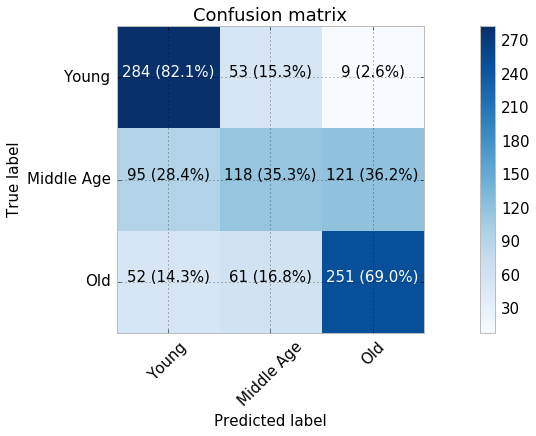

In [144]:
class_names = ['Young', 'Middle Age', 'Old']
score = model.score(x_test[feature_names], Y_test['AgeClassMulti'])
Y_pred = model.predict(x_test[feature_names])

eval_classifier(Y_pred, Y_test['AgeClassMulti'], score, class_names)

Not surprisingly, our model only performed with 62.6% accuracy because multi-class problems are more difficult.  And most of the misclassifications are in the middle class.  However keep in mind that in a three-class classification problem, chance performance is 33.3%, not 50% as in a two-class problem.  Therefore 62.6% accuracy is a significant increase in accuracy above a random guess.  

## Support Vector Machines

Basic support vector machines (SVM) are binary linear classifiers.  That is, similar to Logistic Regression, they attempt to identify a line, plane, or hyperplane to separate one of two classes from the other.  For simplicity this overview will proceed with a two dimensional feature space $x_1 = Height$ and $x_2 = WholeWeight$ and two classes, 'Young' and 'Old'.

To decide whether a new snail should be classified as 'Young' or 'Old' the SVM algorithm will first use the training data to place a linear decision boundary in the feature space.  To pick this decision boundary, the algorithm will try to maximize the distance (otherwise known as the 'margin') between the boundary and each of the closest data points (known as the support vectors) for each class.

Any hyperplane can be described by the equation:

$$\mathbf{w} \cdot \mathbf{x} + b = 0$$

where $\mathbf{w}$ is the vector **normal** (perpendicular) to the hyperplane and $\mathbf{x}$ is the set of points satisfying the above equation.  We will use this equation to describe the decision boundary. 

We can also choose to define the margin hyperplanes for each of the two classes, 'Young' and 'Old', respectively, as:

$$\mathbf{w} \cdot \mathbf{x} + b = -1$$

$$\mathbf{w} \cdot \mathbf{x} + b = 1$$

We next need to make sure that none of the data points fall inside these margin hyperplanes. We can mathematically describe this constraint as:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;For each vector, $\mathbf{x_n}$, containing the values in the feature space of the nth point in our data,

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;if a snail has class -1 ('Young'), then:
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$$\textbf{w} \cdot \mathbf{x_n} - b \leq -1$$

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;and if a snail has class 1 ('Old'), then:
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$$\textbf{w} \cdot \mathbf{x_n} - b \geq 1$$

Now that we've defined the margin hyperplanes and our constriants for them, our goal is maximize the distance between them.  What we will therefore be maximizing is the magnitude, $d$, of a vector that points in the direction from one margin hyperplane to the other.  To get this vector we can normalize $\mathbf{w}$ by its magnitide ${||\mathbf{w}||}$, giving us a unit vector in that direction.  We can multiply this unit vector by $d$, resulting in the vector $d\frac{\mathbf{w}}{||\mathbf{w}||}$, which points from one margin hyperplane to the other and has magnitude $d$.

With the conventions of our hyperplane definitions the distance between the two hyperplanes, $d$, can be defined in terms of $\mathbf{w}$.  Though we will not walk through this derivation, it can be shown that $d = \frac{2}{||\mathbf{w}||}$.  We can therefore maximize $d$ by minimizing $||\mathbf{w}||$.  

In other words, the SVM algorithm finds the $\mathbf{w}$ with the smallest possible $||\mathbf{w}||$ that respects the constraints such that no data points cross the margin hyperplanes.  The data points that fall directly on the margin hyperplanes determine the maximum possible distance between the margin hyperplanes and are called **support vectors**.  


The following figure shows a cartoon example of such an optimal hyperplane in a two class classification task.  Each circle represents a data point and the color of the circles represents the data point's class.  The two axes are features, such as the physical features of our Abalone snails, like *Height* and *Weight*.  Circles with an outline are the support vectors, data points that fall onto the margin hyperplanes (dashed lines).  The algorithm gets its named from these points because those are the only points necessary to define the decision boundary (solid line).

<img src="../images/svm.png" width="500">

The above example is a very simple case with clear separation between classes, and margin hyperplanes and is solved using a **hard margin** method - that is, as per our constraints none of the data points are allowed to fall inside the margin.  In real data separation is hardly ever that clean, and data points will typically overlap, making a hard margin approach unworkable.  To address this, SVMs have been expanded to support **soft margins** so that some data points can fall into the margin.  In that case, the approach used is to simultaneously maximize the margin while also minimizing the number of data points falling into it.

In addition to the soft margin extension, SVMs have been extended to handle more than two classes.  Because SVMs are inherently two-class classifiers - much moreso than a classifier like Logistic Regression that has a natural multi-class extension - in order to implement multi-class SVM a series of two-class SVMs are built, one for each class.  These classifiers then perform a series of one-versus-all classifications.  For example, in our 3 class age groups, we would first build an SVM for 'Young', with the classes 'Young' and 'Not Young' (where 'Not Young' is 'Old' and 'Middle Age').  We would build two more such SVMs for each remaining class.  Then, a new snail would be classified according to the SVM that gives it the largest margin from its decision boundary.

## Classification

Of course, now that we know what the algorithm does, we don't have to worry about solving for the boundary ourselves or even fitting multiple SVMs for a multi-class classification.  We can once again use sklearn's SVM implementation to do the work for us.

In [145]:
from sklearn.svm import LinearSVC

feature_names = ['M', 'F', 'I', 'Length', 'Diameter', 'Height', 'WholeWeight', 'ShuckedWeight', 'VisceraWeight',
                'ShellWeight']
model = LinearSVC()
model.fit(x_train[feature_names], Y_train['AgeClassMulti'].to_frame())

/usr/local/lib/python2.7/dist-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

Percent of correct classifications = 64.27


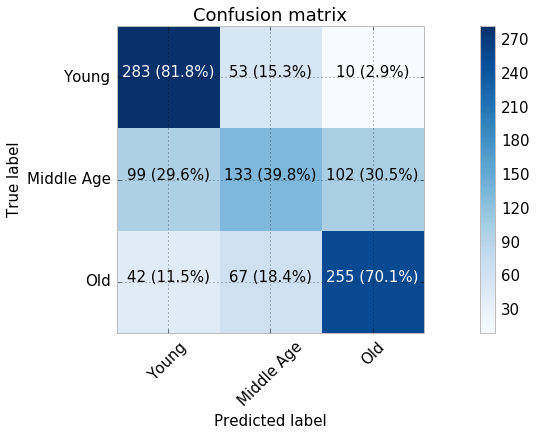

In [146]:
class_names = ['Young', 'Middle Age', 'Old']
score = model.score(x_test[feature_names], Y_test['AgeClassMulti'])
Y_pred = model.predict(x_test[feature_names])

eval_classifier(Y_pred, Y_test['AgeClassMulti'], score, class_names)

The accuracy of the classifier in our data is 64.3%, slightly higher than the Logistic Regression classifier.

## Regression

SVMs have also been expanded to perform regression.  Here we demonstrate an example of how SVM regression can be done with sklearn.

In [195]:
from sklearn.svm import LinearSVR
model = LinearSVR()
model.fit(x_train[feature_names], Y_train['Age'].to_frame())

/usr/local/lib/python2.7/dist-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
     intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
     random_state=None, tol=0.0001, verbose=0)

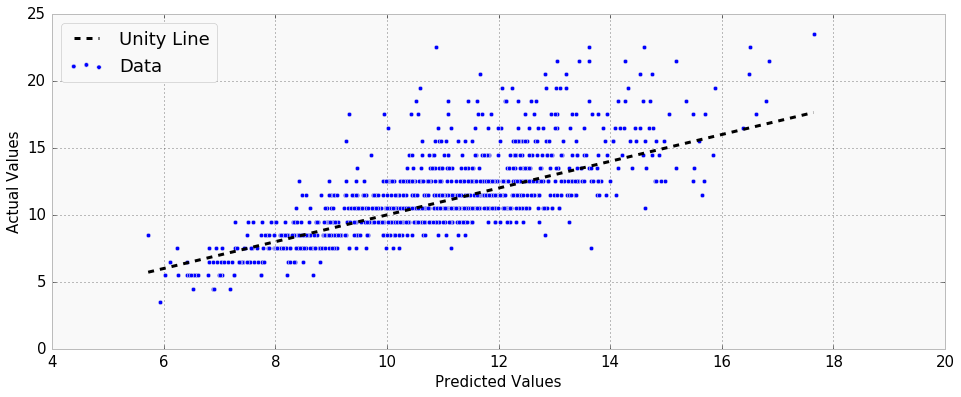

RMSE Test = 2.17755851155
RMSE Train = 2.35847542876


In [196]:
Y_pred = model.predict(x_test[feature_names])
Y_predTr = model.predict(x_train[feature_names])

eval_regressor(Y_pred, Y_test['Age'], Y_predTr, Y_train['Age'])

# Kernel Trick:  Using Linear Classifiers to Solve Linearly Inseperable Problems

We have thus far described machine learning classifiers that create linear decision boundaries.  However, often times data cannot be separated and classified with a linear decision boundary.  In part 2 of the tutorial **[INSERT LINK]** we will discuss other classifiers that can produce decision boundaries that are not linear - that is, they are not lines or hyperplanes, but are free to take any shape.  But before we discuss these non-linear classifiers, we first turn our attention to something called the **kernel trick**.  

The kernel trick is a method that can allow linear classifiers to produce decision boundaries that are non-linear.  More technically, the kernel trick uses a kernel function to remap data that is not linearly seperable to a higher dimensional feature space so as to introduce linear seperability.  Linear classifiers are then applied and select an appropriate linear decision boundary in this higher dimensional space. That is, the classifiers themselves still technically use a linear decision boundary.  However, the data is then mapped back to the original feature space, along with the decision boundary.  When the decision boundary is remapped, it can be non-linear in the original feature space.

The following figure shows an intuitive illustration of how this is done.  The panel on the left shows two classes (red, blue) of data in a feature space with two features.  There is no straight line that can separate the two classes, yet the classes are clearly different and separable using a circular boundary.

<img src="../images/kernel_trick.png">

The middle panel shows the same data after the kernel trick has been applied to it.  If the kernel function used is a Gaussian, an intuitive approximation of the kernel trick can be summarized as replacing each data point with a 2-dimensional Gaussian centered at that point and with an amplitude coming out of (or going into) the computer screen.  Blue points are replaced with a Gaussian with an amplitude of -1 and go into the screen, and red points are replaced with a Gaussian with an amplitude of +1 and come out of the screen.  When all of those Gaussians are added up they add another feature to each data point along an orthogonal dimension - it's distance into or out of the computer screen.  The middle panel illustrates the new, 3-dimensional feature space with the new feature added in a dimension orghogonal to the original feature space.  

As shown in the middle panel, we can now trivially apply a classifier with a linear decision boundary (2D plane) to our data.  The panel on the right shows the data and the decision boundary (gray circle) remapped back to the original 2-dimensional feature space.  The decision boundary in this space appears circular.  The kernel trick has thus allowed us to use a linear classifier to classify data that is not linearly seperable!  

Let's implement the kernel trick with our SVM classifier to see how this is done and how it performs.  We will use Gaussian kernel, otherwise known as a Radial Basis Function (RBF) kernel.  We will also set the gamma hyperparameter to 2.  For RBF kernel in sklearn, intuitively this parameter controls how wide each data point's Gaussian is.  The smaller the gamma, the wider the influence of each data point on the feature space, and the smoother the decision boundary.  The larger the gamma, the narrower the influence of each data point, and the more jagged the decision boundary.  If gamma is too small we are in danger of underfitting our data because our decision boundary does not have enough freedom to closely follow the data points.  If gamma is too large we are in danger of overfitting our data because our boundary has too much freedom and in addition to fitting the data it will also be fitting noise.

In [15]:
from sklearn.svm import SVC
model = SVC(kernel = 'rbf', gamma = 2)
model.fit(x_train[feature_names], Y_train['AgeClassMulti'].to_frame())

/usr/local/lib/python2.7/dist-packages/sklearn/svm/base.py:472: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y_ = column_or_1d(y, warn=True)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0, degree=3, gamma=2,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

Percent of correct classifications = 64.85


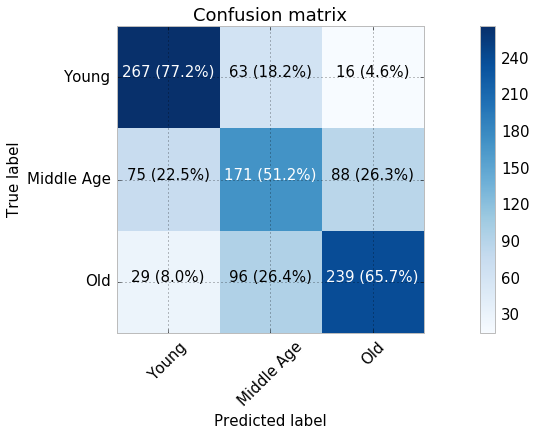

In [16]:
class_names = ['Young', 'Middle Age', 'Old']
score = model.score(x_test[feature_names], Y_test['AgeClassMulti'])
Y_pred = model.predict(x_test[feature_names])

eval_classifier(Y_pred, Y_test['AgeClassMulti'], score, class_names)
plt.show()

We can see that with a non-linear decision boundary we get a slight improvement in classification of 64.9% correct classifications.

# Conclusions

In Part 1 of this tutorial we introduced and defined supervised learning in the context of machine learning algorithms.  We then explored a number of different algorithms that are best-suited for solving linearly seperable problems and built simple models with these algorithms for regression and classification.  Finally we introduced the **kernel trick**, a method that can allow these algorithms to solve problems that are not linearly seperable.

In Part 2 of the Supervised Learning tutorial, we will review a number of algorithms with decision boundaries that are inherently non-linear and which are well-suited for finding solutions that are not linearly seperable.  **[Part 2 Tutorial Link]**